In [2]:
# Colab
!pip install --upgrade matplotlib seaborn google-cloud-bigquery

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery
from google.oauth2 import service_account

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery

client = bigquery.Client(project='still-mesh-488107-j5')

In [4]:
funnel_sql = """
WITH funnel AS (
  SELECT COUNT(DISTINCT user_id) AS total_visitors
  FROM `still-mesh-488107-j5.cosmetics_data.all_events`
),
view_stage AS (
  SELECT COUNT(DISTINCT user_id) AS viewers
  FROM `still-mesh-488107-j5.cosmetics_data.all_events`
  WHERE event_type='view'
),
cart_stage AS (
  SELECT COUNT(DISTINCT user_id) AS cart_adders
  FROM `still-mesh-488107-j5.cosmetics_data.all_events`
  WHERE event_type='cart'
),
purchase_stage AS (
  SELECT COUNT(DISTINCT user_id) AS buyers
  FROM `still-mesh-488107-j5.cosmetics_data.all_events`
  WHERE event_type='purchase'
)
SELECT
  f.total_visitors,
  v.viewers,
  c.cart_adders,
  p.buyers,
  SAFE_DIVIDE(v.viewers,f.total_visitors) AS view_rate,
  SAFE_DIVIDE(c.cart_adders,v.viewers) AS add_to_cart_rate,
  SAFE_DIVIDE(p.buyers,c.cart_adders) AS purchase_rate
FROM funnel f
CROSS JOIN view_stage v
CROSS JOIN cart_stage c
CROSS JOIN purchase_stage p;
"""

funnel_df = client.query(funnel_sql).to_dataframe()
funnel_df

,total_visitors,viewers,cart_adders,buyers,view_rate,add_to_cart_rate,purchase_rate
0,1639358,1597754,398308,110518,0.974622,0.249292,0.277469


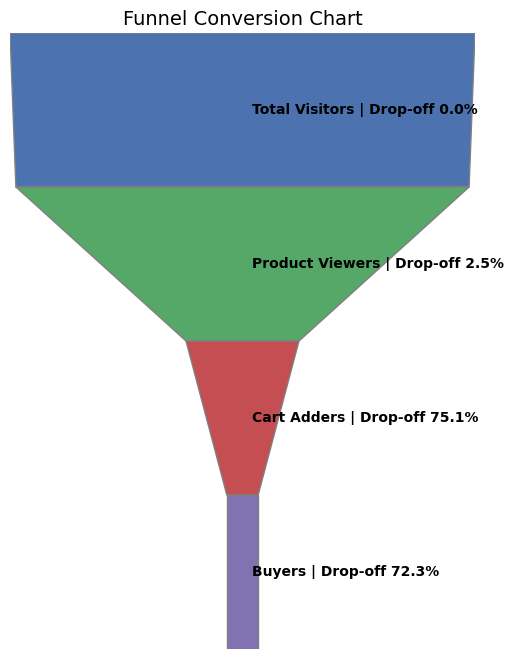

In [35]:
# Funnel Visualisation
import matplotlib.patches as patches

# Extracting data from a DataFrame
total_visitors = funnel_df['total_visitors'][0]
viewers = funnel_df['viewers'][0]
cart_adders = funnel_df['cart_adders'][0]
buyers = funnel_df['buyers'][0]

stages = ['Total Visitors', 'Product Viewers', 'Cart Adders', 'Buyers']
counts = [total_visitors, viewers, cart_adders, buyers]

# Calculate the width ratio of each funnel layer (normalized to 1.0).
max_count = max(counts)
widths = [c/max_count for c in counts]

# set color for stages
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']

# plot
fig, ax = plt.subplots(figsize=(6,8))
ax.set_xlim(0,1)
ax.set_ylim(0,len(stages))
ax.axis('off')

# Draw a funnel, representing each layer with a polygon
for i in range(len(stages)):
    y_top = len(stages)-i
    y_bottom = len(stages)-i-1
    next_width = widths[i+1] if i < len(stages)-1 else widths[i]

    polygon = patches.Polygon([
        (0.5 - widths[i]/2, y_top),
        (0.5 + widths[i]/2, y_top),
        (0.5 + next_width/2, y_bottom),
        (0.5 - next_width/2, y_bottom)
    ], closed=True, facecolor=colors[i], edgecolor='gray')
    ax.add_patch(polygon)

    # CALCULATE drop-off rate
    drop_off = 0 if i == 0 else 1 - counts[i]/counts[i-1]

    ax.annotate(f"{stages[i]} | Drop-off {drop_off*100:.1f}%",
                xy=(0.52, y_bottom + 0.5),
                ha='left', va='center',
                fontsize=10, color='black', fontweight='bold')

plt.title("Funnel Conversion Chart", fontsize=14)
plt.show()

In [9]:
# Top 10 Categories
category_funnel_sql = """
WITH category_summary AS (
  SELECT
    category_id,
    COUNT(DISTINCT CASE WHEN event_type='view' THEN user_id END) AS viewers,
    COUNT(DISTINCT CASE WHEN event_type='cart' THEN user_id END) AS cart_adders,
    COUNT(DISTINCT CASE WHEN event_type='purchase' THEN user_id END) AS buyers,
    SAFE_DIVIDE(
      COUNT(DISTINCT CASE WHEN event_type='cart' THEN user_id END),
      COUNT(DISTINCT CASE WHEN event_type='view' THEN user_id END)
    ) AS add_to_cart_rate,
    SAFE_DIVIDE(
      COUNT(DISTINCT CASE WHEN event_type='purchase' THEN user_id END),
      COUNT(DISTINCT CASE WHEN event_type='cart' THEN user_id END)
    ) AS purchase_rate
  FROM `still-mesh-488107-j5.cosmetics_data.all_events`
  GROUP BY category_id
)
SELECT *
FROM category_summary
ORDER BY viewers DESC
LIMIT 10
"""

category_funnel_df = client.query(category_funnel_sql).to_dataframe()
category_funnel_df

,category_id,viewers,cart_adders,buyers,add_to_cart_rate,purchase_rate
0,1487580013841613016,110211,19839,6315,0.180009,0.318312
1,1487580005092295511,108088,61055,23478,0.564864,0.384539
2,1487580013950664926,102391,16859,4483,0.164653,0.265911
3,1487580008246412266,98813,31881,11384,0.322640,0.357078
4,1487580006300255120,88649,12538,3492,0.141434,0.278513
5,1602943681873052386,83671,36427,12594,0.435360,0.345733
6,1487580005268456287,64866,47350,19800,0.729966,0.418163
7,1487580006317032337,58949,37590,15927,0.637670,0.423703
8,1487580007675986893,58033,34535,13437,0.595092,0.389084
9,1487580005595612013,55163,37530,12078,0.680347,0.321823


In [10]:
# Top 10 Brands
brand_funnel_sql = """
WITH brand_summary AS (
  SELECT
    brand,
    COUNT(DISTINCT CASE WHEN event_type='view' THEN user_id END) AS viewers,
    COUNT(DISTINCT CASE WHEN event_type='cart' THEN user_id END) AS cart_adders,
    COUNT(DISTINCT CASE WHEN event_type='purchase' THEN user_id END) AS buyers,
    SAFE_DIVIDE(
      COUNT(DISTINCT CASE WHEN event_type='cart' THEN user_id END),
      COUNT(DISTINCT CASE WHEN event_type='view' THEN user_id END)
    ) AS add_to_cart_rate,
    SAFE_DIVIDE(
      COUNT(DISTINCT CASE WHEN event_type='purchase' THEN user_id END),
      COUNT(DISTINCT CASE WHEN event_type='cart' THEN user_id END)
    ) AS purchase_rate
  FROM `still-mesh-488107-j5.cosmetics_data.all_events`
  GROUP BY brand
)
SELECT *
FROM brand_summary
ORDER BY viewers DESC
LIMIT 10
"""

brand_funnel_df = client.query(brand_funnel_sql).to_dataframe()
brand_funnel_df

,brand,viewers,cart_adders,buyers,add_to_cart_rate,purchase_rate
0,None,777438,254925,85849,0.327904,0.336762
1,runail,193942,92607,35411,0.477498,0.382379
2,irisk,153750,80769,30391,0.525327,0.376271
3,grattol,106093,49325,17150,0.464922,0.347694
4,estel,92359,27330,9190,0.295911,0.336261
5,kapous,92035,21724,7217,0.236041,0.332213
6,masura,81397,41337,12799,0.507844,0.309626
7,jessnail,78408,17410,5633,0.222044,0.323550
8,concept,62752,17359,5601,0.276629,0.322657
9,ingarden,54166,35303,12231,0.651756,0.346458


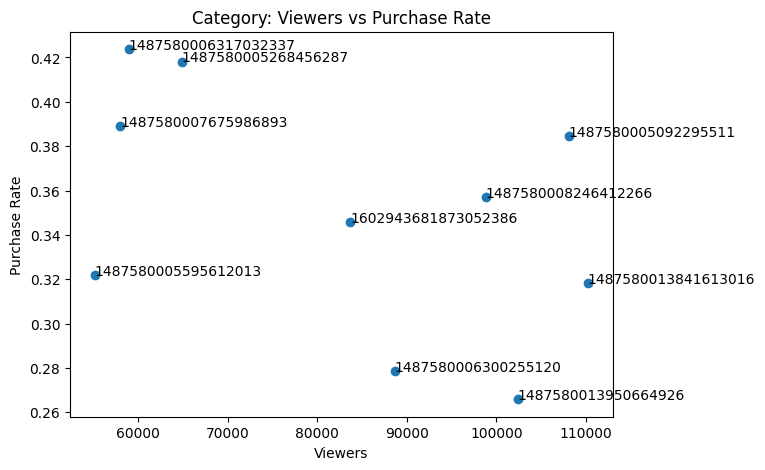

In [11]:
# Observe the difference between high traffic and high conversion rate.
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(category_funnel_df['viewers'], category_funnel_df['purchase_rate'])
for i, cat in enumerate(category_funnel_df['category_id']):
    plt.text(category_funnel_df['viewers'][i], category_funnel_df['purchase_rate'][i], str(cat))
plt.xlabel("Viewers")
plt.ylabel("Purchase Rate")
plt.title("Category: Viewers vs Purchase Rate")
plt.show()

In [12]:
# TOP 10 category id and brand
category_brand_funnel_sql = """
WITH cb_summary AS (
  SELECT
    category_id,
    brand,
    COUNT(DISTINCT CASE WHEN event_type='view' THEN user_id END) AS viewers,
    COUNT(DISTINCT CASE WHEN event_type='cart' THEN user_id END) AS cart_adders,
    COUNT(DISTINCT CASE WHEN event_type='purchase' THEN user_id END) AS buyers,
    SAFE_DIVIDE(
      COUNT(DISTINCT CASE WHEN event_type='cart' THEN user_id END),
      COUNT(DISTINCT CASE WHEN event_type='view' THEN user_id END)
    ) AS add_to_cart_rate,
    SAFE_DIVIDE(
      COUNT(DISTINCT CASE WHEN event_type='purchase' THEN user_id END),
      COUNT(DISTINCT CASE WHEN event_type='cart' THEN user_id END)
    ) AS purchase_rate
  FROM `still-mesh-488107-j5.cosmetics_data.all_events`
  GROUP BY category_id, brand
)
SELECT *
FROM cb_summary
WHERE category_id IN (SELECT category_id FROM `still-mesh-488107-j5.cosmetics_data.all_events`
                      GROUP BY category_id ORDER BY COUNT(DISTINCT user_id) DESC LIMIT 5)
   OR brand IN (SELECT brand FROM `still-mesh-488107-j5.cosmetics_data.all_events`
                GROUP BY brand ORDER BY COUNT(DISTINCT user_id) DESC LIMIT 5)
ORDER BY viewers DESC
"""

cb_funnel_df = client.query(category_brand_funnel_sql).to_dataframe()
cb_funnel_df.head(10)

,category_id,brand,viewers,cart_adders,buyers,add_to_cart_rate,purchase_rate
0,1602943681873052386,grattol,83670,36398,12594,0.435019,0.346008
1,1487580013950664926,None,69436,11283,2953,0.162495,0.261721
2,1487580013841613016,kapous,61251,7463,2431,0.121843,0.325740
3,1487580005092295511,None,52449,31086,11020,0.592690,0.354500
4,1487580008246412266,None,30697,10625,3307,0.346125,0.311247
5,1487580005092295511,uno,30421,15417,5732,0.506788,0.371797
6,1487580008246412266,estel,30231,10445,3478,0.345506,0.332982
7,1487580005134238553,runail,27225,20807,6465,0.764261,0.310713
8,1487580013841613016,None,26483,6844,1867,0.258430,0.272794
9,1487580005092295511,grattol,22136,13324,3933,0.601915,0.295182


In [15]:
# calculate drop-off
cb_funnel_df['add_to_cart_dropoff'] = 1 - cb_funnel_df['add_to_cart_rate']
cb_funnel_df['purchase_dropoff'] = 1 - cb_funnel_df['purchase_rate']

# select TOP 10 rows
top_cb_df = cb_funnel_df.head(10)

# view result
print(top_cb_df[['category_id', 'brand', 'viewers', 'cart_adders', 'buyers',
                 'add_to_cart_rate', 'purchase_rate',
                 'add_to_cart_dropoff', 'purchase_dropoff']])

           category_id    brand  viewers  cart_adders  buyers  \
0  1602943681873052386  grattol    83670        36398   12594   
1  1487580013950664926     None    69436        11283    2953   
2  1487580013841613016   kapous    61251         7463    2431   
3  1487580005092295511     None    52449        31086   11020   
4  1487580008246412266     None    30697        10625    3307   
5  1487580005092295511      uno    30421        15417    5732   
6  1487580008246412266    estel    30231        10445    3478   
7  1487580005134238553   runail    27225        20807    6465   
8  1487580013841613016     None    26483         6844    1867   
9  1487580005092295511  grattol    22136        13324    3933   

   add_to_cart_rate  purchase_rate  add_to_cart_dropoff  purchase_dropoff  
0          0.435019       0.346008             0.564981          0.653992  
1          0.162495       0.261721             0.837505          0.738279  
2          0.121843       0.325740             0.878157 

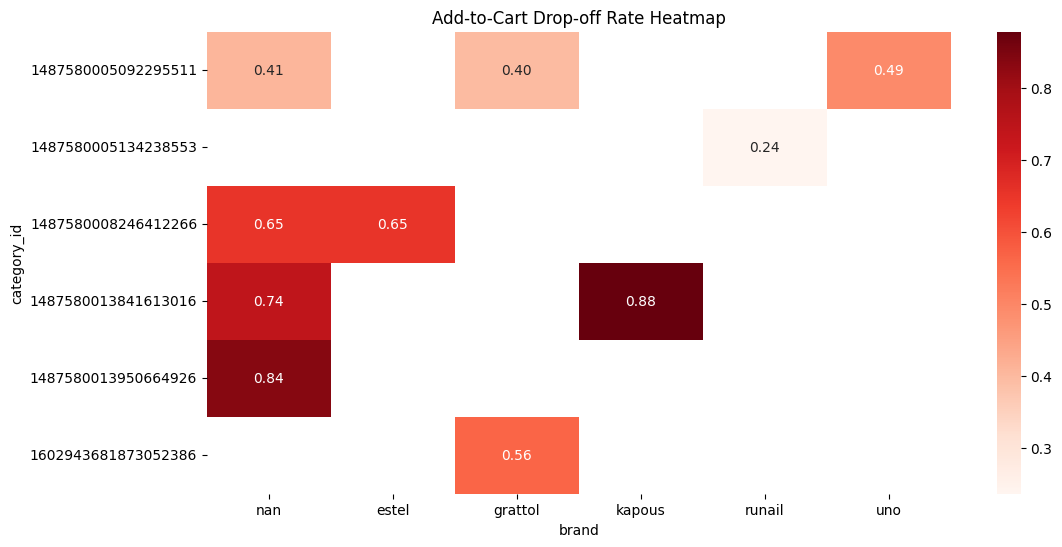

In [16]:
# visualisation
# Add-to-Cart Drop-off Rate
# generate pivot table
heatmap_data = top_cb_df.pivot(index='category_id', columns='brand',
                               values='add_to_cart_dropoff')

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Reds")
plt.title("Add-to-Cart Drop-off Rate Heatmap")
plt.show()

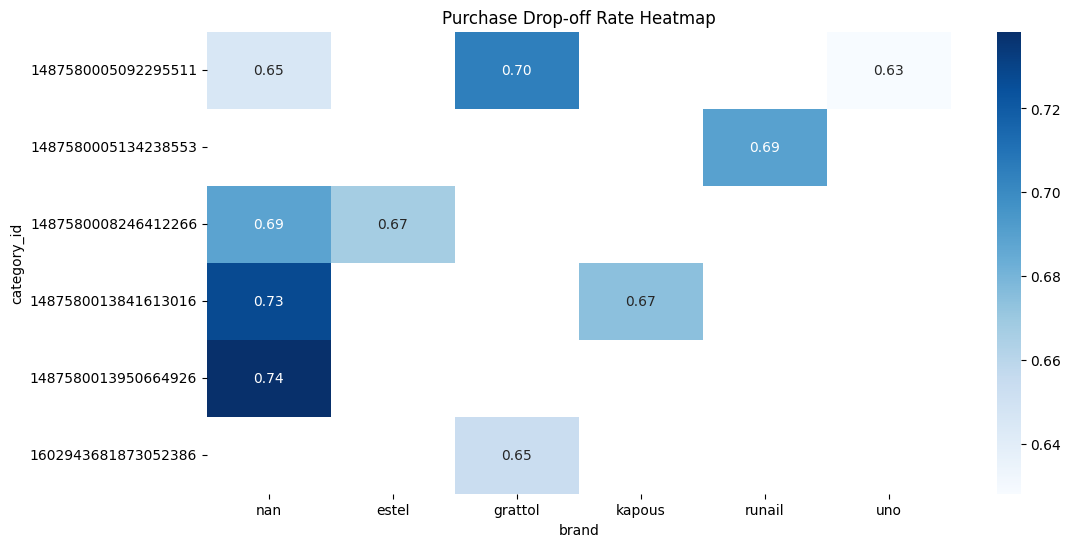

In [18]:
# purchase drop-off
heatmap_data_purchase = top_cb_df.pivot(index='category_id', columns='brand',
                                        values='purchase_dropoff')

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data_purchase, annot=True, fmt=".2f", cmap="Blues")
plt.title("Purchase Drop-off Rate Heatmap")
plt.show()

In [23]:
# Visualisation for Cohort Analysis
from google.colab import files

uploaded = files.upload()

Saving cohort_result.csv to cohort_result.csv


In [24]:
# read cohort result
df = pd.read_csv('cohort_result.csv')
print(df.head())
print(df.dtypes)

              cohort_month           activity_month  active_users  \
0  2019-10-01 00:00:00 UTC  2019-10-01 00:00:00 UTC         25762   
1  2019-10-01 00:00:00 UTC  2019-11-01 00:00:00 UTC          4763   
2  2019-10-01 00:00:00 UTC  2019-12-01 00:00:00 UTC          3293   
3  2019-10-01 00:00:00 UTC  2020-01-01 00:00:00 UTC          3399   
4  2019-10-01 00:00:00 UTC  2020-02-01 00:00:00 UTC          2692   

   cohort_users  retention_rate  months_since_first_purchase  
0         25762        1.000000                            0  
1         25762        0.184885                            1  
2         25762        0.127824                            2  
3         25762        0.131939                            3  
4         25762        0.104495                            4  
cohort_month                       str
activity_month                     str
active_users                     int64
cohort_users                     int64
retention_rate                 float64
months_since

In [26]:
# check data format
df['cohort_month'] = pd.to_datetime(df['cohort_month'], errors='coerce')
df['activity_month'] = pd.to_datetime(df['activity_month'], errors='coerce')

print(df[df['cohort_month'].isna()])
print(df[df['activity_month'].isna()])

Empty DataFrame
Columns: [cohort_month, activity_month, active_users, cohort_users, retention_rate, months_since_first_purchase]
Index: []
Empty DataFrame
Columns: [cohort_month, activity_month, active_users, cohort_users, retention_rate, months_since_first_purchase]
Index: []


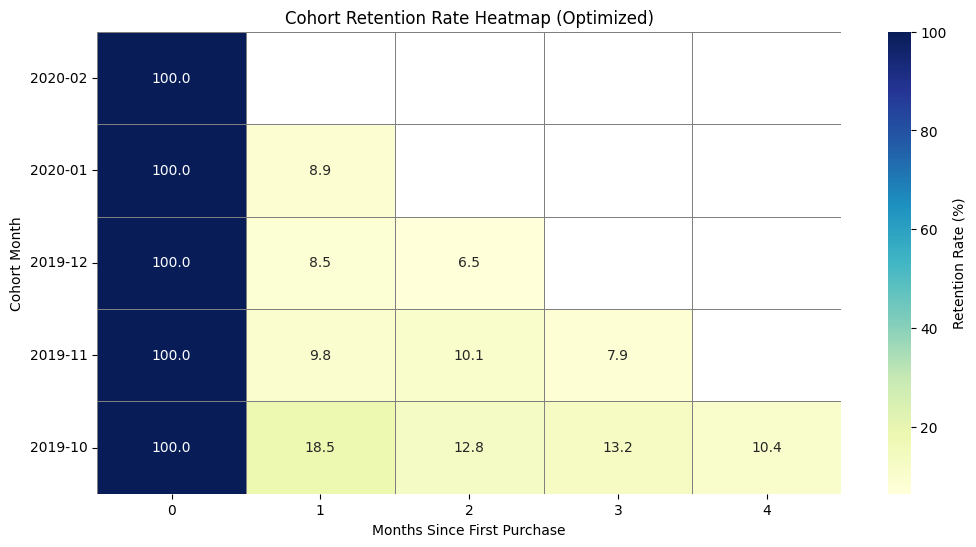

In [29]:

# Convert to datetime
df['cohort_month'] = pd.to_datetime(df['cohort_month'], errors='coerce')
df['activity_month'] = pd.to_datetime(df['activity_month'], errors='coerce')

# Ensure that retention_rate is a float
df['retention_rate'] = pd.to_numeric(df['retention_rate'], errors='coerce')

# Pivot matrix
retention_matrix = df.pivot(index='cohort_month',
                            columns='months_since_first_purchase',
                            values='retention_rate')

# Reverse row order: latest cohort on top
retention_matrix = retention_matrix.sort_index(ascending=False)

# Draw a heat map
plt.figure(figsize=(12, 6))

# Create a color map to highlight the maximum retention
mask = np.zeros_like(retention_matrix)
for i in range(retention_matrix.shape[0]):
    row = retention_matrix.iloc[i]
    if not row.isna().all():
        max_col = row.idxmax()
        mask[i, retention_matrix.columns.get_loc(max_col)] = True

sns.heatmap(retention_matrix*100,          # Convert to percentage
            annot=True,
            fmt=".1f",                     # one decimal place
            cmap="YlGnBu",
            cbar_kws={'label': 'Retention Rate (%)'},
            linewidths=0.5,
            linecolor='gray')

# Beautify the coordinate axis
plt.title("Cohort Retention Rate Heatmap (Optimized)")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.yticks(np.arange(len(retention_matrix.index))+0.5,
           [d.strftime("%Y-%m") for d in retention_matrix.index], rotation=0)
plt.show()